In [1]:
import numpy as np
import matplotlib.pylab as plt
import cv2
from matplotlib import image
import os

In [2]:
from scipy import ndimage

In [3]:
filter_directory = os.path.join(os.getcwd(),"bin_filter_images/trial_3/")
filter_names = ['ram_filter','ramp_filter','rod_filter','hyp_filter','hypp_filter','soma_filter']

In [4]:
# load all filters (they are saved as np.array)
filters = dict()


# also normolize the filters since the intensities of the mach filters
# are very small (max. value 0.0012 for ram_filter)

def normalize(image):
    image = image/np.max(image)
    return image

for i in filter_names:
    filters[i] = normalize(np.loadtxt(filter_directory+"/"+i+".txt",)) # read in ndarray

1.0


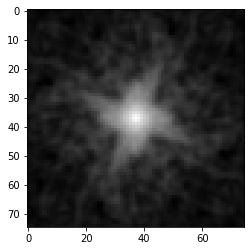

In [5]:
# save the ram_filter as a .png file, then using cv2.imread to load again
plt.imshow(filters['ram_filter'],cmap='gray')
print (np.max(filters['ram_filter']))

In [6]:
# construct a image using these filters with gaussian noise
def add_gaussian_noise(image,var=0.1):
    
    dimes = image.shape
    mean = 0.0
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,dimes)
    #gauss = gauss.reshape(dimes)
    noisy = image + gauss
    return noisy
    
    

In [7]:
print (np.min(filters['ram_filter']),np.max(filters['ram_filter']))

0.0 1.0


In [8]:
nram_filter = add_gaussian_noise(filters['ram_filter'],var=0.003)

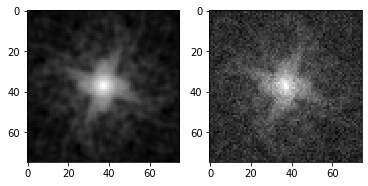

In [9]:
plt.subplot(1,2,1)
plt.imshow(filters['ram_filter'],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(nram_filter,cmap='gray')

In [10]:
# get the PSD of each filter
aa = np.fft.fft2(filters['ram_filter'])


In [11]:
from scipy import ndimage

In [12]:
def azimuthally_psd(image,bins=30):
    '''
    generate the PSD along radial direction
    '''
    fftimage = np.fft.fft2(image)
    
    dimes = fftimage.shape
    centerX = int(dimes[0]/2)
    centerY = int(dimes[1]/2)
    maskimage = np.ones(dimes)
    maskimage[centerX,centerY] = 0
    
    edt_mask = ndimage.distance_transform_edt(maskimage)
    
    ori_psd = np.log(np.abs(np.fft.fftshift(fftimage))**2)
    # max radial length
    mlen = np.sqrt(centerX**2+centerY**2)
    spacing = mlen/bins
    
    
    psd = []
    dist = []
    for i in np.arange(bins):
        low_limit = i*spacing
        high_limit = (i+1)*spacing
        dist_i = 0.5*(low_limit + high_limit)
        
        indx = np.logical_and(np.greater_equal(edt_mask,low_limit),np.less(edt_mask,high_limit))
        psd_i = np.sum(ori_psd[indx])/np.sum(maskimage[indx])
        psd.append(psd_i)
        dist.append(dist_i)
        
    return dist,psd

In [13]:
psd = dict()

for i in filters.keys():
    psd[i] = azimuthally_psd(filters[i])
    

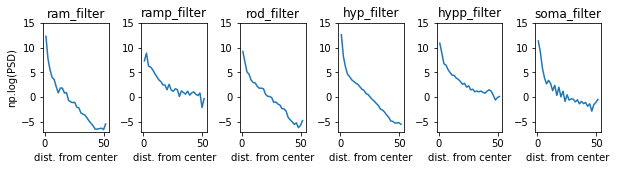

In [14]:

n=0
plt.figure(figsize=(10,2))
for i in filters.keys():
    n += 1
    plt.subplot(1,6,n)
    plt.plot(psd[i][0],psd[i][1])
    plt.subplots_adjust(wspace=0.5)
    plt.ylim([-7,15])
    plt.title(i)
    if n == 1:
        plt.ylabel('np.log(PSD)')
    plt.xlabel('dist. from center')

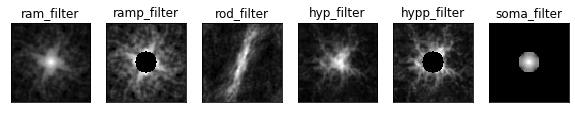

In [15]:
n=0
plt.figure(figsize=(10,10))
for i in filters.keys():
    n += 1
    plt.subplot(1,6,n)
    plt.imshow(filters[i],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(i)

In [16]:
# now construct a large image using the ram_filter, rod_filter and hyp_filter

perct = {
    'ram_filter': 0.2,
    'rod_filter': 0.3,
    'hyp_filter': 0.5
}

In [17]:
def construct_test_image(filternames,perct=None, nRows=50,nCols=50):
    '''
    construct a test image (size = nRows x nCols filters) using filternames (a list containts the name)
    and the percentage of each filter
    '''
    filter_dimes = np.shape(filters[filternames[0]])
    image_size_x = filter_dimes[0]*nRows
    image_size_y = filter_dimes[1]*nCols
    
    test_image = np.ones((image_size_x,image_size_y))
    
    
    numFilters = len(filternames) # the number of filters
    
    for m in np.arange(nRows):
        for n in np.arange(nCols):
            prob = np.random.rand()
            for j in np.arange(numFilters):
                    if j == 0:
                        left = 0
                    else: 
                        left = np.sum(perct[0:j])
                    right = left + perct[j]
                    if prob >= left and prob <= right:
                        indx = j

            test_image[m*filter_dimes[0]:(m+1)*filter_dimes[0],\
                        n*filter_dimes[1]:(n+1)*filter_dimes[1]] = filters[filternames[indx]]
            
    # now add some gaussian noise
    test_image = add_gaussian_noise(test_image,var=0.003)
       
    return test_image

In [36]:
perct = [0.6,0.2,0.2]
test_image = construct_test_image(['ram_filter','rod_filter','hyp_filter'],perct=perct\
                                 ,nRows=10,nCols=30)

([], <a list of 0 Text yticklabel objects>)

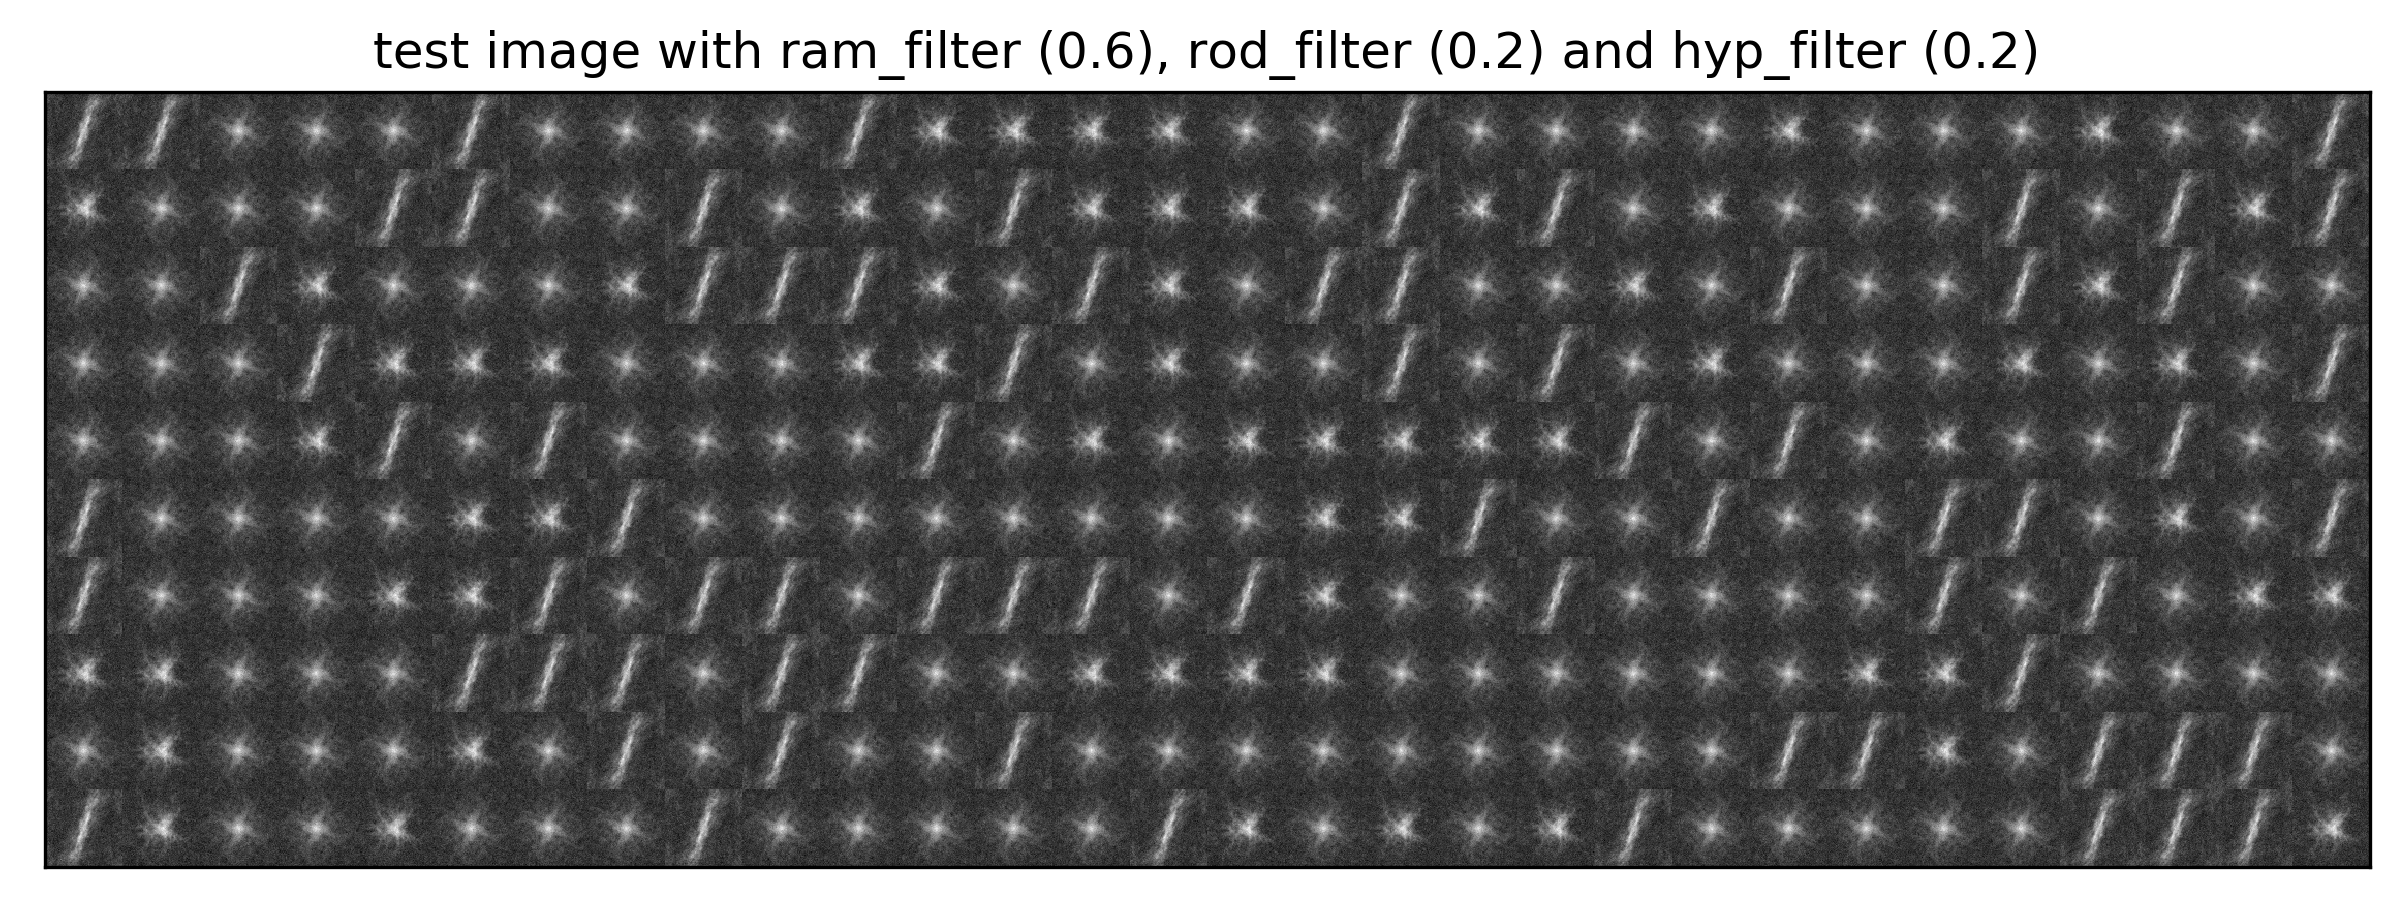

In [37]:
plt.figure(figsize=(10,10),dpi=300)
plt.imshow(test_image,cmap='gray')
plt.title('test image with ram_filter (%s), rod_filter (%s) \
and hyp_filter (%s)' %  (str(perct[0]),str(perct[1]),str(perct[2])))
plt.xticks([])
plt.yticks([])

In [22]:
# manually construct a ram_filter that has 1/2 of its original intensity
filters['dimmer_ram_filter'] = filters['ram_filter'].copy()
filters['dimmer_ram_filter'] = 0.5*filters['dimmer_ram_filter']

Text(0.5, 1.0, 'dimmer_ram_filter')

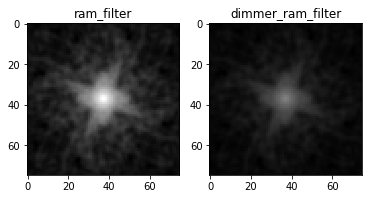

In [28]:
plt.subplot(1,2,1)
plt.imshow(filters['ram_filter'],cmap='gray',vmax=1)
plt.title('ram_filter')
plt.subplot(1,2,2)
plt.imshow(filters['dimmer_ram_filter'],cmap='gray',vmax=1)
plt.title('dimmer_ram_filter')

In [42]:
perct = [0.6,0.2,0.2]
test_image = construct_test_image(['dimmer_ram_filter','rod_filter','hyp_filter'],perct=perct\
                                 ,nRows=10,nCols=30)

([], <a list of 0 Text yticklabel objects>)

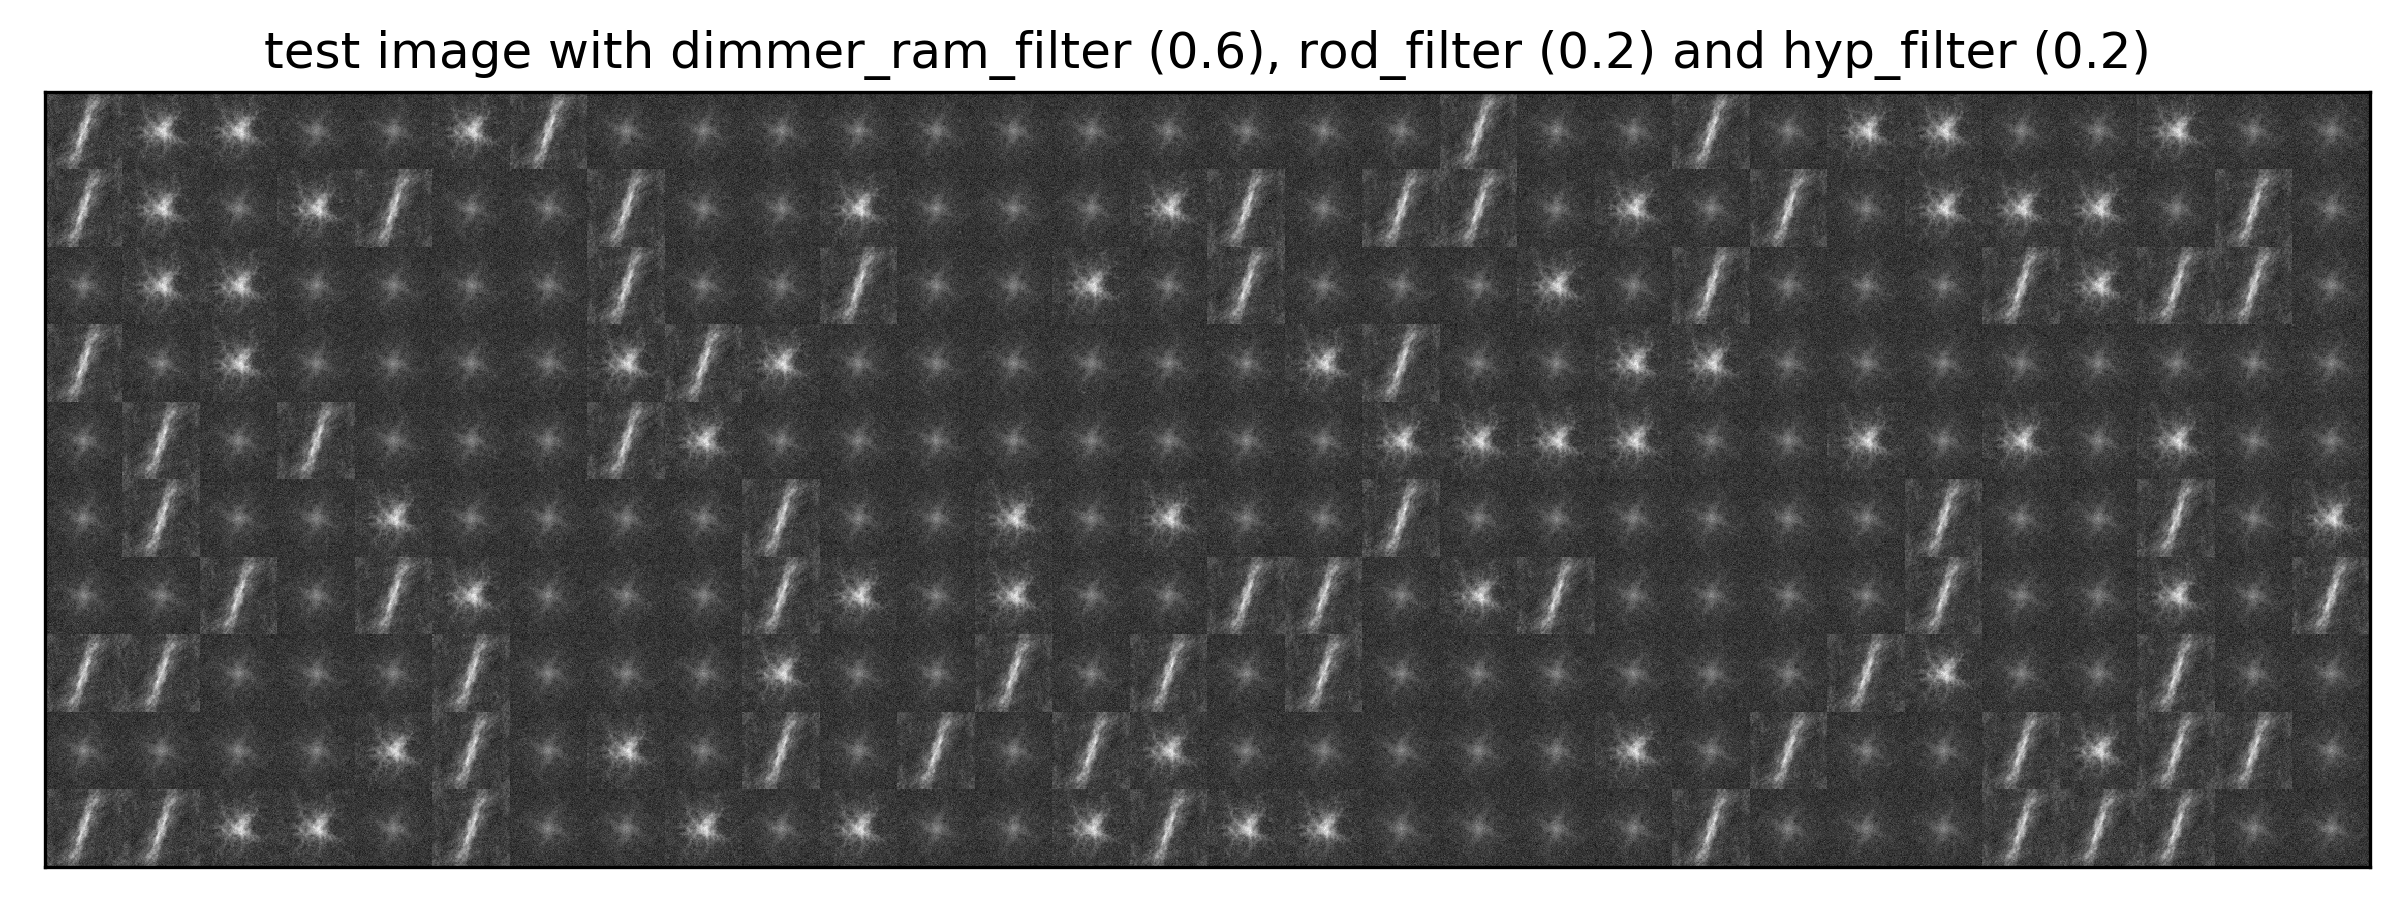

In [43]:
plt.figure(figsize=(10,10),dpi=300)
plt.imshow(test_image,cmap='gray')
plt.title('test image with dimmer_ram_filter (%s), rod_filter (%s) \
and hyp_filter (%s)' %  (str(perct[0]),str(perct[1]),str(perct[2])))
plt.xticks([])
plt.yticks([])

In [44]:
ram_resp = ndimage.convolve(test_image,filters['ram_filter'])
rod_resp = ndimage.convolve(test_image,filters['rod_filter'])
hyp_resp = ndimage.convolve(test_image,filters['hyp_filter'])

In [53]:
vmax = np.amax([np.max(ram_resp),np.max(rod_resp),np.max(hyp_resp)])

([], <a list of 0 Text yticklabel objects>)

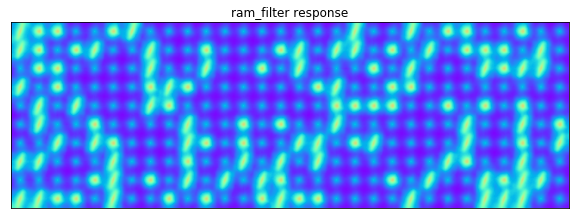

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(ram_resp,cmap='rainbow',vmax=vmax)
plt.title('ram_filter response')
plt.xticks([])
plt.yticks([])
#plt.colorbar()

([], <a list of 0 Text yticklabel objects>)

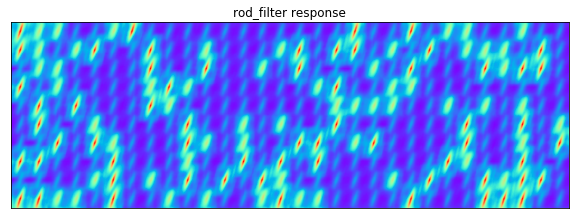

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(rod_resp,cmap='rainbow',vmax=vmax)
plt.title('rod_filter response')
plt.xticks([])
plt.yticks([])
#plt.colorbar()

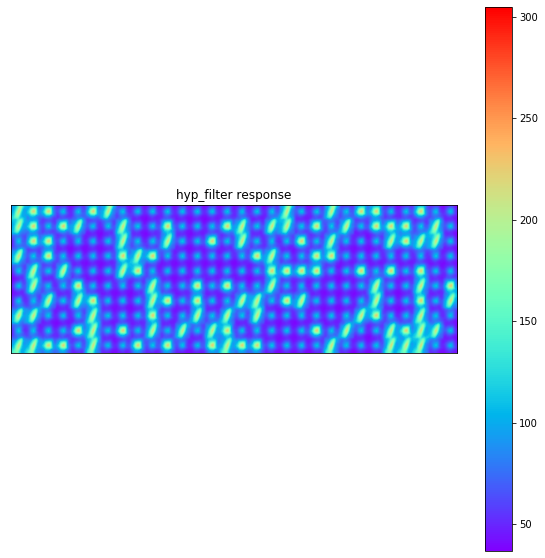

In [63]:
plt.figure(figsize=(10,10))
plt.imshow(hyp_resp,cmap='rainbow',vmax=vmax)
plt.title('hyp_filter response')
plt.xticks([])
plt.yticks([])
plt.colorbar()

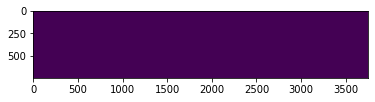

In [23]:
plt.imshow(tt)

In [16]:
idx = np.greater_equal(edt,10)
cc = edt.copy()
cc[idx] = 0

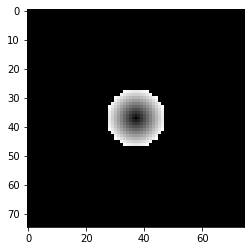

In [17]:
plt.imshow(cc,cmap='gray')

In [ ]:
plt.plot(psd)

In [31]:
aa = cv2.imread(filter_directory+'ramp_filter.png',0) # read in gray_scale_mode

In [37]:
print (np.min(aa),np.max(aa))

30 215


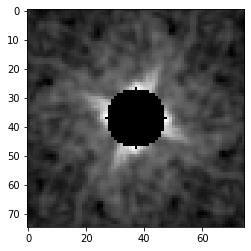

In [33]:
plt.imshow(aa,cmap='gray')